In [1]:
import tqdm
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
# from datasets import Dataset

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments


# from transformers import AutoTokenizer, AutoModel, BertForSequenceClassification, Trainer, TrainingArguments

In [4]:
train_data = pd.read_csv(filepath_or_buffer='/kaggle/input/imdb-reviews/test.csv', on_bad_lines='skip')
test_data = pd.read_csv(filepath_or_buffer='/kaggle/input/imdb-reviews/test.csv', on_bad_lines='skip')

In [5]:
train_data

,text,label
0,"Based on an actual story, John Boorman shows t...",1
1,This is a gem. As a Film Four production - the...,1
2,"I really like this show. It has drama, romance...",1
3,This is the best 3-D experience Disney has at ...,1
4,"Of the Korean movies I've seen, only three had...",1
...,...,...
24995,With actors like Depardieu and Richard it is r...,0
24996,If you like to get a couple of fleeting glimps...,0
24997,When something can be anything you want it to ...,0
24998,"I had heard good things about ""States of Grace...",0


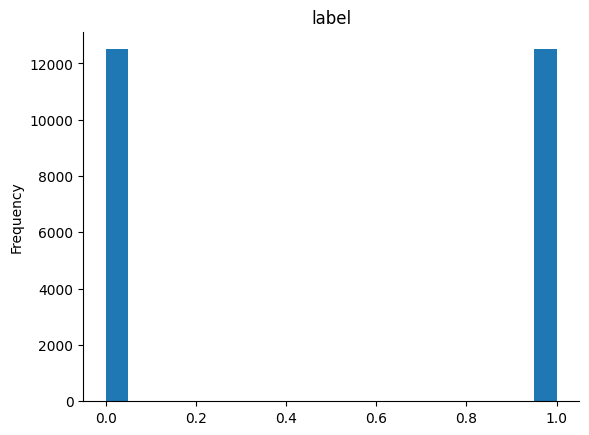

In [7]:
# @title train_data_label

from matplotlib import pyplot as plt
train_data['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [13]:
test_data

,text,label
0,"Based on an actual story, John Boorman shows t...",1
1,This is a gem. As a Film Four production - the...,1
2,"I really like this show. It has drama, romance...",1
3,This is the best 3-D experience Disney has at ...,1
4,"Of the Korean movies I've seen, only three had...",1
...,...,...
24995,With actors like Depardieu and Richard it is r...,0
24996,If you like to get a couple of fleeting glimps...,0
24997,When something can be anything you want it to ...,0
24998,"I had heard good things about ""States of Grace...",0


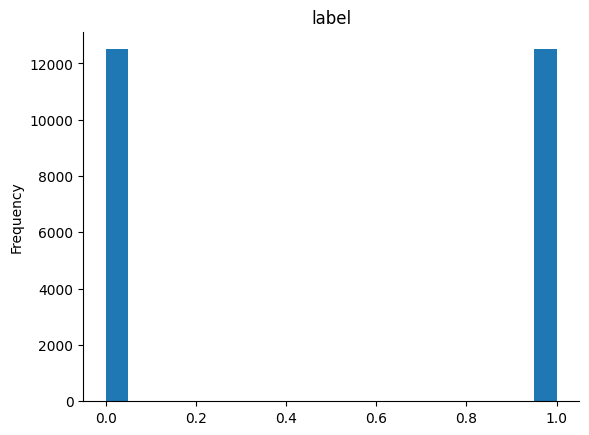

In [14]:
# @title test_data_label

from matplotlib import pyplot as plt
test_data['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [15]:
!nvidia-smi

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Tue Oct  1 18:56:53 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [18]:
train_labels = train_data['label'].to_list()
train_text = train_data['text'].to_list()

test_labels = test_data['label'].to_list()
test_text = test_data['text'].to_list()

In [19]:
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('google-bert/bert-base-uncased').to('cuda')

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:  31%|###       | 136M/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
train_encodings = tokenizer(train_text, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_text, truncation=True, padding=True, max_length=512)

In [ ]:
train_encodings

In [26]:
class MyDataset(Dataset):
    def __init__(self, encodings, labels, device=None):
        super().__init__()
        self.encodings = encodings
        self.labels = labels
        self.device = device

    def __getitem__(self, index):
        item = {key: torch.tensor(val[index]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[index])
        return item

    def __len__(self):
        return len(self.labels)

In [28]:
train_dataset = MyDataset(train_encodings, train_labels, device='gpu')
test_dataset = MyDataset(test_encodings, test_labels, device='gpu')

In [29]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_eval_batch_size=32,
    per_device_train_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs'
)

In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [31]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
500,0.335000
1000,0.192800
1500,0.134400
2000,0.058100


TrainOutput(global_step=2346, training_loss=0.1600305556437955, metrics={'train_runtime': 4141.1888, 'train_samples_per_second': 18.111, 'train_steps_per_second': 0.567, 'total_flos': 1.9733329152e+16, 'train_loss': 0.1600305556437955, 'epoch': 3.0})

In [35]:
trainer.evaluate()

{'eval_loss': 0.015393883921205997,
 'eval_runtime': 398.3432,
 'eval_samples_per_second': 62.76,
 'eval_steps_per_second': 1.963,
 'epoch': 3.0}

In [36]:
model.save_pretrained('./fine-tuned-bert')
tokenizer.save_pretrained('./fine-tuned-bert')

('./fine-tuned-bert/tokenizer_config.json',
 './fine-tuned-bert/special_tokens_map.json',
 './fine-tuned-bert/vocab.txt',
 './fine-tuned-bert/added_tokens.json')

In [43]:
import torch.nn.functional as F

In [54]:
# Подготовка текста
text = "Thats pretty nice film. I got a lot of pleasure after watching this"
inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to('cuda')

# Предсказание
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    probabilities = torch.softmax(logits, dim=1)

# Извлечение вероятности для предсказанного класса
predicted_probability = probabilities[0][predicted_class].item()


# Интерпретация результата
class_names = {0: 'Отрицательный', 1: 'Положительный'}
print(f'Предсказанный класс: {class_names[predicted_class]}')
print(f'Вероятность: {predicted_probability:.4f}')

Предсказанный класс: Положительный
Вероятность: 0.9509


In [37]:
!zip -r output.zip /kaggle/working/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/results/ (stored 0%)
  adding: kaggle/working/results/checkpoint-1500/ (stored 0%)
  adding: kaggle/working/results/checkpoint-1500/rng_state.pth (deflated 25%)
  adding: kaggle/working/results/checkpoint-1500/config.json (deflated 48%)
  adding: kaggle/working/results/checkpoint-1500/trainer_state.json (deflated 59%)
  adding: kaggle/working/results/checkpoint-1500/scheduler.pt (deflated 55%)
  adding: kaggle/working/results/checkpoint-1500/model.safetensors (deflated 7%)
  adding: kaggle/working/results/checkpoint-1500/optimizer.pt (deflated 11%)
  adding: kaggle/working/results/checkpoint-1500/training_args.bin (deflated 51%)
  adding: kaggle/working/results/checkpoint-1000/ (stored 0%)
  adding: kaggle/working/results/checkpoint-1000/rng_state.pth (deflated 25%)
  adding: kaggle/working/results/checkpoint-1000/config.json (deflated 48%)
  adding: kaggle/working/results/checkpoint-1000/trainer_state.json (deflated 57%)
 

In [40]:
from IPython.display import FileLink
FileLink(r'output.zip')

/kaggle/working/output.zip